In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
%cd /content/drive/MyDrive/cs7643/project/cs7643-project
%ls

/content/drive/MyDrive/cs7643/project/cs7643-project
 data/             LICENSE                'old_style_transfer copy.py'   style_transfer.py
 eval_metrics.py   module.py               __pycache__/
 fcn.py            nst_experiments.ipynb   README.md


In [4]:
# Import necessary libraries
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from style_transfer import StyleTransfer
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
import torch
import torchvision.models as models
import torch.nn as nn
from eval_metrics import FeatureExtractor  # Ensure this points to the script location
from eval_metrics import StyleRepresentationEvaluator
from PIL import Image
import torchvision.transforms as transforms

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 97.9MB/s]


Building the style transfer model..


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing..
run [50]:
Style Loss : 4.501301 Content Loss: 4.096346

run [100]:
Style Loss : 1.160905 Content Loss: 3.063858

run [150]:
Style Loss : 0.730299 Content Loss: 2.666647

run [200]:
Style Loss : 0.492298 Content Loss: 2.500321

run [250]:
Style Loss : 0.351864 Content Loss: 2.409254

run [300]:
Style Loss : 0.265982 Content Loss: 2.350511



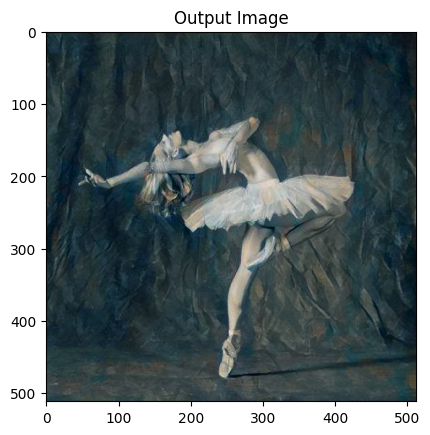

PSNR: 22.33881949415754
SSIM: 0.7978728567538425


In [5]:
# Create an instance of the style transfer class with the paths to your images
content_img_path = "/content/drive/MyDrive/cs7643/project/cs7643-project/data/images/dancing.jpg"
style_img_path = "/content/drive/MyDrive/cs7643/project/cs7643-project/data/images/picasso.jpg"
style_transfer = StyleTransfer(content_img_path, style_img_path)

# Run the style transfer
output = style_transfer.run_style_transfer(style_transfer.content_img, style_transfer.style_img, style_transfer.content_img.clone())

# Display the output
StyleTransfer.imshow(output, title='Output Image')

# Show the plot in the notebook
plt.show()

# Convert the images to the range [0, 255] and type uint8 for PSNR and SSIM comparison
content_img_for_metrics = style_transfer.content_img.mul(255).clamp(0, 255).byte().permute(0, 2, 3, 1).cpu().numpy()
output_img_for_metrics = output.mul(255).clamp(0, 255).byte().permute(0, 2, 3, 1).cpu().numpy()

# Calculate PSNR
psnr_value = psnr(content_img_for_metrics[0], output_img_for_metrics[0], data_range=255)

# Calculate SSIM
ssim_value, ssim_full_map = ssim(content_img_for_metrics[0], output_img_for_metrics[0], channel_axis=-1, full=True)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

# Save the resulting image to a file
#style_transfer.save_output_image(output, "/content/drive/MyDrive/cs7643/project/cs7643-project/data/images/output.jpg")


In [6]:
# Preprocess function for images
def preprocess_image(image, target_size=(224, 224)):
    preprocess = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(image).unsqueeze(0)  # Add batch dimension


In [7]:
# Initialize VGG with the layers up to the relu4_2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_model = models.vgg19(pretrained=True).to(device)

# Create the feature extractor object
feature_extractor = FeatureExtractor(vgg_model).to(device)

# Replace 'path_to_your_image.jpg' with the actual file paths
content_image_path = '/content/drive/MyDrive/cs7643/project/cs7643-project/data/images/dancing.jpg'
generated_image_path = '/content/drive/MyDrive/cs7643/project/cs7643-project/data/images/experiment_0.jpg'

content_image = Image.open(content_image_path)
generated_image = Image.open(generated_image_path)

# Preprocess the images
content_tensor = preprocess_image(content_image).to(device)
generated_tensor = preprocess_image(generated_image).to(device)

# Extract features
content_features = feature_extractor(content_tensor)
generated_features = feature_extractor(generated_tensor)

# Compute cosine similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
similarity = cos(content_features.flatten(start_dim=1),
                 generated_features.flatten(start_dim=1))

print(f'Feature-based similarity (cosine): {similarity.item()}')


Feature-based similarity (cosine): 0.6617040634155273


In [9]:
# Example usage:
evaluator = StyleRepresentationEvaluator().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
loss = evaluator('/content/drive/MyDrive/cs7643/project/cs7643-project/data/images/dancing.jpg', '/content/drive/MyDrive/cs7643/project/cs7643-project/data/images/picasso.jpg')

print(f'Style Representation (Gram Matrix) Loss: {loss.item()}')




NameError: ignored